In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import emcee
import glob
import h5py
import pandas as pd
from scipy.interpolate import interp1d
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm_notebook

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

Load GWTC-1:

In [3]:
zs_interp = expm1(linspace(log(1), log(2+1), 1000))
ds_interp = Planck15.luminosity_distance(zs_interp).to(u.Mpc).value
z_of_d = interp1d(ds_interp, zs_interp)

posts = []
for fn in tqdm_notebook(glob.glob('GWTC-1/*.hdf5')):
    with h5py.File(fn, 'r') as f:
        ds = array(f['Overall_posterior']['luminosity_distance_Mpc'])
        z = z_of_d(ds)
        m1 = array(f['Overall_posterior']['m1_detector_frame_Msun'])/(1+z)
        m2 = array(f['Overall_posterior']['m2_detector_frame_Msun'])/(1+z)
        ct1 = array(f['Overall_posterior']['costilt1'])
        ct2 = array(f['Overall_posterior']['costilt2'])
        a1 = array(f['Overall_posterior']['spin1'])
        a2 = array(f['Overall_posterior']['spin2'])
        chi_eff = (m1*a1*ct1 + m2*a2*ct2)/(m1+m2)
        posts.append(pd.DataFrame({'m1': m1, 'm2': m2, 'z': z, 'chi_eff': chi_eff}))

It is hard (impossible?) to write down the LALInference prior on $\chi_\mathrm{eff}$ in closed form; much easier to just simulate it.

In [4]:
def simulate_chi_eff_prior(size=1):
    mas = np.random.uniform(size=size)
    mbs = np.random.uniform(size=size)
    m1s = where(mas > mbs, mas, mbs)
    m2s = where(mas > mbs, mbs, mas)
    
    ct1s = np.random.uniform(low=-1, high=1, size=size)
    ct2s = np.random.uniform(low=-1, high=1, size=size)
    
    a1s = np.random.uniform(size=size)
    a2s = np.random.uniform(size=size)
    
    return (m1s*ct1s*a1s + m2s*ct2s*a2s)/(m1s+m2s)

It looks like this:

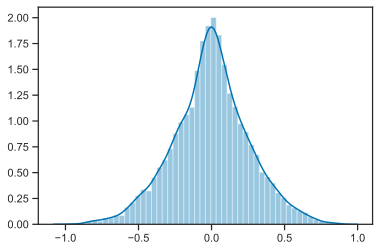

In [9]:
sns.distplot(simulate_chi_eff_prior(10000))

Here we construct a KDE approximation to teh above distribution; from the plot above, we see that we don't need to do anything fancy to handle the limited domain.

In [10]:
chi_effs_prior = simulate_chi_eff_prior(10000)
approx_chi_eff_li_prior = ss.gaussian_kde(chi_effs_prior)

This computes the LALInference prior in *source-frame* masses, redshift, and $\chi_\mathrm{eff}$:

In [11]:
def li_prior_wt(z, chieff):
    return (1+z)**2*Planck15.luminosity_distance(z).to(u.Mpc).value**2*(Planck15.comoving_distance(z).to(u.Mpc).value + (1+z)*Planck15.hubble_distance.to(u.Mpc).value / Planck15.efunc(z))*approx_chi_eff_li_prior(chieff)

Add a column for the LI prior:

In [13]:
for p in tqdm_notebook(posts):
    p['li_prior_wt'] = li_prior_wt(p['z'], p['chi_eff'])

This computes the "population" prior for the dimensions that *aren't* $\chi_\mathrm{eff}$.  Note that we *ignore* the mass bounds on the population prior (absolute mass doesn't really affect $\chi_\mathrm{eff}$ anyway, so this should be safe).

In [14]:
MMin = 5
def pop_prior_wt(m1, m2, z):
    return 1.0/m1/(m1-MMin)*(1+z)**1.7*Planck15.differential_comoving_volume(z).to(u.Mpc**3/u.sr).value*4*pi

Add the column:

In [15]:
for p in posts:
    p['pop_prior_wt'] = pop_prior_wt(p['m1'], p['m2'], p['z'].values)

We can draw samples from the population-marginalized likelihood in $\chi_\mathrm{eff}$ by re-weighting; we check that the effective number of samples is reasonable for each likelihood.

Neff = 326
Neff = 20701
Neff = 1665
Neff = 421
Neff = 3327
Neff = 14702
Neff = 844
Neff = 540
Neff = 2258
Neff = 370


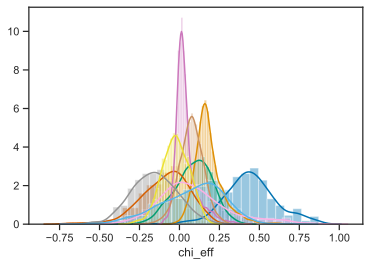

In [39]:
likelihoods = []
for p in posts:
    wts = p['pop_prior_wt']/p['li_prior_wt']
    rs = np.random.uniform(low=0, high=np.max(wts), size=len(wts))
    s = rs < wts
    sns.distplot(p['chi_eff'][s])
    likelihoods.append(p[s])
for l in likelihoods:
    print('Neff = {:d}'.format(len(l)))

Now we load the selection function (actually using design sensitivity, but the shape is identical for design and early):

In [19]:
with h5py.File('design-selected.h5', 'r') as f:
    chi_eff_sel = array(f['chi_effs'])

This object implements the posterior on the population parameters $\mu$ and $\sigma$.  A quick description; for more info, see [Mandel, Farr & Gair (2019)](http://dx.doi.org/10.1093/mnras/stz896), [Farr (2019)](http://dx.doi.org/10.3847/2515-5172/ab1d5f), and references therein.

We assume that the *population* distribution for $\chi_\mathrm{eff}$ is 
$$
\chi_\mathrm{eff} ~ N\left( \mu, \sigma \right) T[-1, 1],
$$
where the notation $T[-1,1]$ means to *truncate* the normal distribution to the range $[-1, 1]$.  The marginal likelihood for the catalog data $d_{GW}$ given $\mu$ and $\sigma$ and incorporating selection effects is 
$$
p\left( \mu, \sigma \mid d_{GW} \right) = \prod_{i=1}^{N} \frac{1}{\alpha\left( \mu, \sigma \right)} \int \mathrm{d} \chi_\mathrm{eff}^{(i)} p\left( d_{GW}^{(i)} \mid \chi_\mathrm{eff}^{(i)} \right) p\left(\chi_\mathrm{eff}^{(i)} \mid \mu, \sigma \right),
$$
where 
$$
\alpha\left( \mu, \sigma \right) = \int \mathrm{d} \chi_\mathrm{eff} P_\mathrm{det}\left( \chi_\mathrm{eff} \right) p\left( \chi_\mathrm{eff} \mid \mu, \sigma \right),
$$
is the population-averaged detection probability.

The integral in the product can be approximated as a weighted sum over samples drawn from the likelihood function $p\left( d_{GW}^{(i)} \mid \chi_\mathrm{eff}^{(i)} \right)$:
$$
\int \mathrm{d} \chi_\mathrm{eff} p\left( d_{GW}^{(i)} \mid \chi_\mathrm{eff} \right) p\left(\chi_\mathrm{eff} \mid \mu, \sigma \right) \propto \frac{1}{N_\mathrm{samp}} \sum_{j=1}^{N_\mathrm{samp}} p\left( \chi_\mathrm{eff}^{(j)} \mid \mu, \sigma \right).
$$

Similarly, $\alpha$ can be approximated as a weighted sum over samples drawn from the detected $\chi_\mathrm{eff}$ distribution:
$$
\alpha\left( \mu, \sigma \right) \propto \frac{1}{N_\mathrm{samp}} \sum_{k=1}^{N_\mathrm{samp}} p\left( \chi_\mathrm{eff}^{(k)} \mid \mu, \sigma \right).
$$
It is important to control the sampling error in this approximation since, unlike the Monte-Carlo approximation for each event, this term appears once *per event* in the likelihood function.  See Farr (2019).

We impose a broad normal prior for $\mu$ and a log-normal prior for $\sigma$.

In [21]:
class GaussianPosterior(object):
    def __init__(self, chi_eff_samples, chi_eff_selected_samples):
        self.ce = chi_eff_samples
        self.ces = chi_eff_selected_samples
        
    def log_pdet_pop_wts(self, mu, sigma):
        popdist = ss.norm(loc=mu, scale=sigma)
        
        return popdist.logpdf(self.ces) - log(popdist.cdf(1.0) - popdist.cdf(-1.0))
    
    def log_mean_pdet(self, log_wts):
        return logaddexp.reduce(log_wts) - log(len(log_wts))
    
    def neff_det(self, log_wts):
        return exp(logaddexp.reduce(log_wts - np.max(log_wts)))
    
    def __call__(self, mu_sig):
        mu, sigma = mu_sig
        
        if sigma < 0:
            return np.NINF # Reject
        
        if mu < -1 or mu > 1:
            return np.NINF # Reject
        
        popdist = ss.norm(loc=mu, scale=sigma)
        
        lp = ss.lognorm(0.5, scale=1/sqrt(3)).logpdf(sigma) + ss.norm(loc=0, scale=1).logpdf(mu)
        
        ll = 0.0
        for x in self.ce:
            ll += logaddexp.reduce(popdist.logpdf(x)) - log(len(x))
        
        log_pop_wts = self.log_pdet_pop_wts(mu, sigma)
        neff_det = self.neff_det(log_pop_wts)
        log_mean_pdet = self.log_mean_pdet(log_pop_wts)

        if neff_det < 5*len(self.ce):
            return np.NINF # Reject steps with neff < 5*N (safety factor)
        
        ll -= len(self.ce)*log_mean_pdet
        ll += len(self.ce)*(3 + len(self.ce))/(2*neff_det)
        ll -= len(self.ce)*log(popdist.cdf(1.0) - popdist.cdf(-1.0))
        
        return lp + ll

We set up 16 walkers, and initialize them by the prior:

In [43]:
nw = 16
mus = np.random.uniform(low=-1, high=1, size=nw)
sigmas = np.random.lognormal(0, 0.25, size=nw)
chain = column_stack((mus, sigmas))

Set up the posterior object, feed it 128 samples from each event's likelihood, and 1024 samples (should be enough to reliably estimate $\alpha$) from the detection probability.

In [40]:
logpost = GaussianPosterior([np.random.choice(l['chi_eff'], size=128) for l in likelihoods], chi_eff_sel[:1024])

How fast is it?

In [41]:
%timeit logpost([0.0, 1.0])

4.37 ms ± 573 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Set up sampler object:

In [42]:
sampler = emcee.EnsembleSampler(nw, 2, logpost)

Run the sampler for a small number of steps, and see if it reaches a stable value of log-likelihood (you may need to reset it and run again several times until the likelihood stabilizes).

In [44]:
chain, lnprobs, rstate = sampler.run_mcmc(chain, 128)

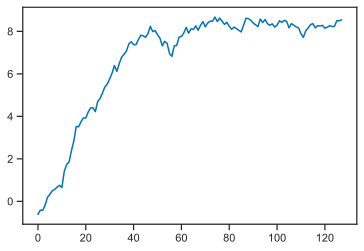

In [45]:
plot(mean(sampler.lnprobability, axis=0))

In [46]:
sampler.reset()

Once the loop above has stabilized the value of the posterior, run for a larger number of steps to actually sample.

In [47]:
chain, lnprobs, rstate = sampler.run_mcmc(chain, 1024)

Check that the log-likelihood has no trend:

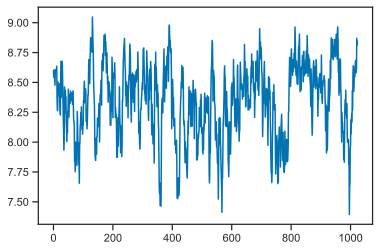

In [48]:
plot(mean(sampler.lnprobability, axis=0))

Feed the sampler to arviz, so that we can make pretty plots, save its chains, etc.

In [31]:
az_sampler = az.from_emcee(sampler, var_names=['mu', 'sigma'])

Traceplot (looks converged):

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b2a4a20>,
      dtype=object)

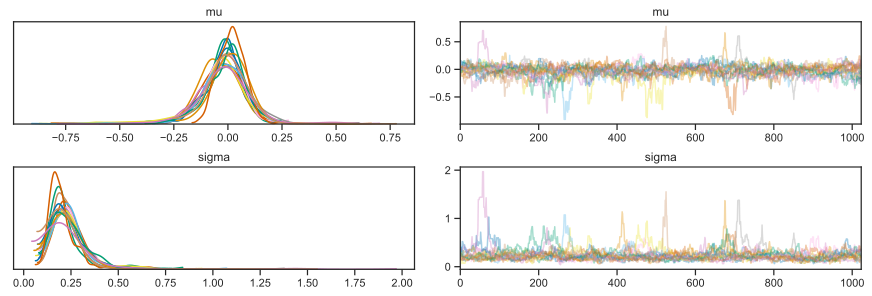

In [32]:
az.plot_trace(az_sampler)

How is the effective sample size?

In [33]:
az.ess(az_sampler)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 333.1
    sigma    float64 448.5

Save the chain:

In [37]:
az.to_netcdf(az_sampler, 'pop-samples.nc')

'pop-samples.nc'

Here, FWIW, is the joint posterior on $\mu$ and $\sigma$ from the GWTC-1 events:

/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/arviz/plots/kdeplot.py:413: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)


(<matplotlib.axes._subplots.AxesSubplot at 0x11a7854e0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11741e4e0>)

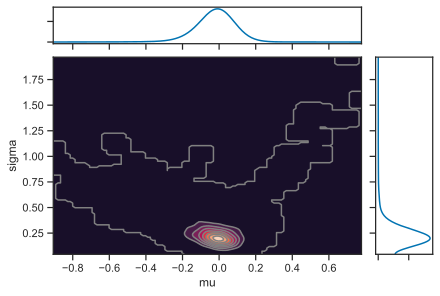

In [34]:
az.plot_joint(az_sampler, var_names=['mu', 'sigma'], kind='kde')

More interesting is to compute the marginal population distribution: for each value of $\mu$ and $\sigma$, draw a random $\chi_\mathrm{eff}$ from the population.  The collection of these $\chi_\mathrm{eff}$ values represents the marginal population.  It is plotted below in blue.  For comparison, in orange is the set of samples from the likelihood functions for the events.

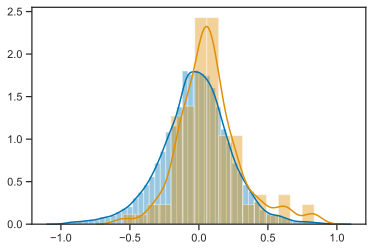

In [49]:
x = ss.norm(scale=az_sampler.posterior.sigma.values, loc=az_sampler.posterior.mu.values).rvs().flatten()
x = x[abs(x)<1]
sns.distplot(x)
sns.distplot(concatenate([random.choice(l['chi_eff'].values, size=10) for l in likelihoods]))

It would be interesting if either $\mu$ were bounded above or below 0 (is the mean $\chi_\mathrm{eff}$ non-zero, and which sign), but it's not.  Similarly, if $\sigma$ were constrained to be near zero, or well-measured (relative to the intrinsic width of $\chi_\mathrm{eff}$, which is 2); but it's not really.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11bace6d8>,
      dtype=object)

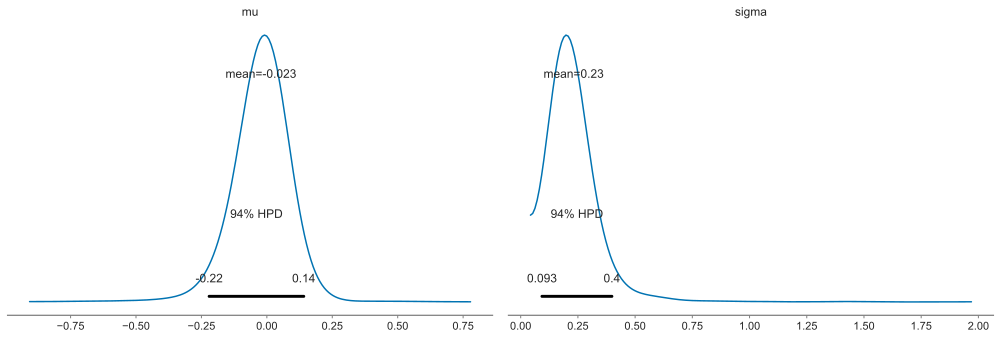

In [36]:
az.plot_posterior(az_sampler, var_names=['mu', 'sigma'])